# Physics-informed Neural Network to solve 1D Second-order Singular Pertubabtion Problem with One-sided Boundary Layer

Author: Shiyao Gu, Jierui Li

$ - \epsilon u'' + b(x) u' + c(x) u = f(x)$

In [33]:
%matplotlib inline
import os, time, math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.autograd as autograd

SEED = 1234
torch.manual_seed(SEED); np.random.seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
OUTDIR = "/Users/shiyaogu/Documents/PINN"; os.makedirs(OUTDIR, exist_ok=True)
print("DEVICE:", DEVICE, "| OUTDIR:", OUTDIR)

DEVICE: cpu | OUTDIR: /Users/shiyaogu/Documents/PINN


## Networks and Tools

In [34]:
def mlp(in_dim, out_dim, width=64, depth=3, act=nn.Tanh):
    layers = [nn.Linear(in_dim, width), act()]
    for _ in range(depth-1):
        layers += [nn.Linear(width, width), act()]
    layers += [nn.Linear(width, out_dim)]
    net = nn.Sequential(*layers)
    for m in net:
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight); nn.init.zeros_(m.bias)
    return net

class OuterRaw(nn.Module):
    def __init__(self, width=64, depth=3):
        super().__init__(); self.net = mlp(1,1,width,depth)
    def forward(self, x): return self.net(x)

class InnerRaw(nn.Module):
    def __init__(self, width=64, depth=3):
        super().__init__(); self.net = mlp(1,1,width,depth)
    def forward(self, s): return self.net(s)

class CoordNet(nn.Module):
    def __init__(self, width=64, depth=2):
        super().__init__(); self.net = mlp(1,1,width,depth)
    def forward(self, x): return x + 0.1*self.net(x)

class DecayRate(nn.Module):
    def __init__(self, lam_min=0.2):
        super().__init__(); self.theta = nn.Parameter(torch.tensor(0.0)); self.lam_min=lam_min
    def forward(self): return torch.nn.functional.softplus(self.theta) + self.lam_min

def grad(y, x):
    return autograd.grad(y, x, grad_outputs=torch.ones_like(y),
                         create_graph=True, retain_graph=True, only_inputs=True)[0]

def second_grad(y, x):
    dy = grad(y, x); return grad(dy, x)

## Sampling and Coordinate

In [35]:
def sample_collocation(nc, nedge, layer_side='right', device=DEVICE):
    x_uni = torch.rand(nc,1,device=device)
    # geometric cluster toward chosen layer side
    k = torch.linspace(0.0, 1.0, nedge, device=device).unsqueeze(1)
    rho = 1e-3 ** k
    x_edge = (1.0 - rho) if (layer_side=='right') else rho
    x = torch.cat([x_uni, x_edge], dim=0).requires_grad_(True)
    return x

def build_s(coord, x, eps, layer_side='right'):
    if layer_side=='right':
        x_ref = torch.ones(1,1,device=x.device); s = (coord(x_ref) - coord(x))/eps
    else:
        x_ref = torch.zeros(1,1,device=x.device); s = (coord(x) - coord(x_ref))/eps
    return s

## Residual

In [36]:
def residual(u, x, eps):
    u_x = grad(u, x); u_xx = second_grad(u, x)
    b, c, f = b_fun(x), c_fun(x), f_fun(x)
    return -eps*u_xx + b*u_x + c*u - f

def w_inner(s, S0=5.0, kappa=2.0): return torch.sigmoid(kappa*(S0 - s))

def w_band(s, S0=5.0, S1=7.0, kappa=2.0):
    left = torch.sigmoid(kappa*(s - S0)); right = torch.sigmoid(kappa*(S1 - s)); return left*right

## Construction of $u_{\text{in}} and u_[\text{out}]$

In [37]:
def outer_transform_bc(x, g_out, bc_side, bc_type, bc_value):
    """Boundary condition enforcement for the outer solution.
    Modes:
      - BC_MODE == 'hard': hard-encode at the *non-layer* boundary (original behavior).
      - BC_MODE == 'soft': do NOT hard-encode; return raw g_out and let loss penalty enforce BC.
    """
    mode = str(globals().get('BC_MODE', 'hard')).lower()
    if mode == 'soft':
        # no transform; purely learned, BC handled by penalty term
        return g_out

    # original hard-encoding:
    if bc_side == 'left':
        t = x
    elif bc_side == 'right':
        t = x - 1.0
    else:
        raise ValueError("bc_side must be 'left' or 'right'")

    if bc_type == 'dirichlet':
        # u_out(bc)=value, u_out = value + (x-bc)*g_out
        return bc_value + t * g_out
    elif bc_type == 'neumann':
        # u_out'(bc)=value, u_out = value*(x-bc) + 0.5*(x-bc)^2*g_out
        return bc_value * t + 0.5 * (t**2) * g_out
    else:
        raise ValueError("bc_type must be 'dirichlet' or 'neumann'")

In [38]:
def inner_transform_dirichlet(s, g_in, target_minus_uout_at_b, lam):
    """Inner layer transform for Dirichlet BC.
    - hard: original form, strictly matching boundary value at s=0
    - soft: no hard match; keep only an exponential envelope for locality
    """
    mode = str(globals().get('BC_MODE', 'hard')).lower()
    if mode == 'soft':
        return torch.exp(-lam * s) * g_in
    # hard (original)
    return torch.exp(-lam * s) * ( target_minus_uout_at_b + s * g_in )

def inner_transform_neumann(s, g_in, target_minus_uout_x_at_b, lam, sgn, phi_x_at_b, eps):
    """Inner layer transform for Neumann BC.
    - hard: original form, strictly matching boundary derivative at s=0
    - soft: no hard match; keep only an exponential envelope for locality
    """
    mode = str(globals().get('BC_MODE', 'hard')).lower()
    if mode == 'soft':
        return torch.exp(-lam * s) * g_in
    # hard (original)
    A = (eps / (sgn * phi_x_at_b)) * target_minus_uout_x_at_b
    return torch.exp(-lam * s) * ( A * s + 0.5 * (s**2) * g_in )

## Forward Components

In [39]:
def forward_components(x, eps, outer_raw, inner_raw, coord, lam_module,
                      layer_side='right',
                      bc_left=('dirichlet', 0.0), bc_right=('dirichlet', 1.0)):
    # which side outer enforces? -> the **non-layer** side
    outer_bc_side = 'left' if layer_side=='right' else 'right'
    inner_bc_side = 'right' if layer_side=='right' else 'left'

    # Unpack BC tuples
    bcL_type, bcL_val = bc_left
    bcR_type, bcR_val = bc_right

    # Outer transform uses the non-layer side BC
    g_out = outer_raw(x)
    if outer_bc_side=='left':
        uout = outer_transform_bc(x, g_out, 'left', bcL_type, bcL_val)
    else:
        uout = outer_transform_bc(x, g_out, 'right', bcR_type, bcR_val)

    # Boundary points & derivatives needed for inner transform
    xL = torch.zeros(1,1,device=x.device, requires_grad=True)
    xR = torch.ones(1,1,device=x.device, requires_grad=True)

    # outer evaluated at boundaries (with the same transform)
    g_out_L = outer_raw(xL); g_out_R = outer_raw(xR)
    if outer_bc_side=='left':
        uout_L = outer_transform_bc(xL, g_out_L, 'left', bcL_type, bcL_val)
        uout_R = outer_transform_bc(xR, g_out_R, 'left', bcL_type, bcL_val)
    else:
        uout_L = outer_transform_bc(xL, g_out_L, 'right', bcR_type, bcR_val)
        uout_R = outer_transform_bc(xR, g_out_R, 'right', bcR_type, bcR_val)

    # derivatives at boundaries
    uout_x_L = grad(uout_L, xL); uout_x_R = grad(uout_R, xR)

    # phi'(boundary) for ds/dx sign factor
    phi_L = coord(xL); phi_R = coord(xR)
    phi_x_L = grad(phi_L, xL); phi_x_R = grad(phi_R, xR)

    # s(x)
    s = build_s(coord, x, eps, layer_side)
    lam = lam_module()
    g_in = inner_raw(s)

    if inner_bc_side=='right':
        # thin layer at right boundary
        sgn = -1.0  # ds/dx|1 = -phi'(1)/eps
        if bcR_type == 'dirichlet':
            target_minus_uout = bcR_val - uout_R
            uin = inner_transform_dirichlet(s, g_in, target_minus_uout, lam)
        else:  # Neumann at right
            target_minus_uout_x = bcR_val - uout_x_R
            uin = inner_transform_neumann(s, g_in, target_minus_uout_x, lam, sgn, phi_x_R, eps)
    else:
        # thin layer at left boundary
        sgn = +1.0  # ds/dx|0 = +phi'(0)/eps
        if bcL_type == 'dirichlet':
            target_minus_uout = bcL_val - uout_L
            uin = inner_transform_dirichlet(s, g_in, target_minus_uout, lam)
        else:  # Neumann at left
            target_minus_uout_x = bcL_val - uout_x_L
            uin = inner_transform_neumann(s, g_in, target_minus_uout_x, lam, sgn, phi_x_L, eps)

    u = uout + uin
    aux = dict(uout=uout, uin=uin, s=s, lam=lam,
               uout_L=uout_L, uout_R=uout_R, uout_x_L=uout_x_L, uout_x_R=uout_x_R,
               phi_x_L=phi_x_L, phi_x_R=phi_x_R,
               bcL_type=bcL_type, bcL_val=bcL_val, bcR_type=bcR_type, bcR_val=bcR_val,
               outer_bc_side=outer_bc_side, inner_bc_side=inner_bc_side)
    return u, (uout, uin, s), aux

## Branch-gated PDE Loss

In [40]:
def pde_branch_losses(x, eps, outer_raw, inner_raw, coord, lam_module,
                      layer_side='right', bc_left=('dirichlet',0.0), bc_right=('dirichlet',1.0),
                      S0=5.0, S1=7.0, kappa=2.0, lam_comp=0.05):
    u, (uout, uin, s),aux = forward_components(x, eps, outer_raw, inner_raw, coord, lam_module,
                                layer_side=layer_side, bc_left=bc_left, bc_right=bc_right)
    s = aux['s']; uout = aux['uout']; uin = aux['uin']

    # inner-only update in inner zone (outer stop-grad); use scaled residual
    u_in_only = uout.detach() + uin
    rin = residual(u_in_only, x, eps); rin_scaled = eps * rin

    # outer-only update in outer zone (inner stop-grad); use original residual
    u_out_only = uout + uin.detach()
    rout = residual(u_out_only, x, eps)

    # weak composite in band
    rcomp = residual(uout+uin, x, eps)

    win = w_inner(s, S0, kappa); wmid = w_band(s, S0, S1, kappa)

    L_pde = torch.mean(win * rin_scaled**2 + (1.0 - win) * rout**2 + 0* lam_comp * wmid * rcomp**2)
    aux.update(dict(rin=rin, rout=rout, rcomp=rcomp, win=win))
    return L_pde, aux

## Loss of $\phi$ and RAR

In [41]:
def loss_phi_reg(coord, tau=0.1, eta_phi=1e-4, nreg=512):
    x = torch.rand(nreg,1,device=DEVICE, requires_grad=True)
    phi = coord(x); phi_x = grad(phi, x); phi_xx = second_grad(phi, x)
    return torch.mean(torch.relu(tau - phi_x)**2) + eta_phi*torch.mean(phi_xx**2)

def rar_select_points(outer_raw, inner_raw, coord, lam_module, eps, layer_side='right', n_cand=6000, topk=256,
                      bc_left=('dirichlet',0.0), bc_right=('dirichlet',1.0)):
    x = torch.rand(n_cand,1,device=DEVICE, requires_grad=True)
    u, _ = forward_components(x, eps, outer_raw, inner_raw, coord, lam_module,
                              layer_side=layer_side, bc_left=bc_left, bc_right=bc_right)
    r = residual(u, x, eps).abs().flatten().detach()
    idx = torch.topk(r, k=min(topk, n_cand)).indices
    sel = x.detach()[idx]
    return [sel[i:i+1,:] for i in range(sel.shape[0])]

## Evaluate and Plot

In [ ]:
def check_BCs(outer_raw, inner_raw, coord, lam_module, eps, layer_side, bc_left, bc_right):
    xL = torch.zeros(1,1,device=DEVICE, requires_grad=True)
    xR = torch.ones(1,1,device=DEVICE, requires_grad=True)
    # small helper: assemble u at a point
    def u_total(xp):
        u, _ ,_ = forward_components(xp, eps, outer_raw, inner_raw, coord, lam_module,
                                  layer_side=layer_side, bc_left=bc_left, bc_right=bc_right)
        return u
    uL = u_total(xL); uR = u_total(xR)
    uL_x = grad(uL, xL); uR_x = grad(uR, xR)
    return float(uL.item()), float(uR.item()), float(uL_x.item()), float(uR_x.item())

def evaluate_and_plot(outer_raw, inner_raw, coord, lam_module, eps, layer_side='right',
                      bc_left=('dirichlet',0.0), bc_right=('dirichlet',1.0),
                      step_tag='eval', outdir=OUTDIR, try_exact=True):
    grid = np.linspace(0,1,2001).reshape(-1,1).astype(np.float64)
    x = torch.tensor(grid, dtype=torch.float32, device=DEVICE, requires_grad=True)

    # forward_components 假设返回 (u, (u_out, u_in, phi))
    u, (u_out, u_in, phi), a = forward_components(
        x, eps, outer_raw, inner_raw, coord, lam_module,
        layer_side=layer_side, bc_left=bc_left, bc_right=bc_right
    )

    u_np     = u.detach().cpu().numpy().reshape(-1)
    u_out_np = u_out.detach().cpu().numpy().reshape(-1)
    u_in_np  = u_in.detach().cpu().numpy().reshape(-1)
    phi_np   = phi.detach().cpu().numpy().reshape(-1)
    if phi_np.size == 1:   # phi 可能是标量，扩展一下
        phi_np = np.full_like(u_np, phi_np.item())

    has_exact = try_exact 
    if has_exact:
        u_ex = exact_solution(grid, eps)
        diff = u_np - u_ex.reshape(-1)
        errL2 = float(np.sqrt(np.mean(diff**2))); errInf = float(np.max(np.abs(diff)))
    else:
        u_ex = None; errL2 = errInf = None

    # --- 原始 u(x) 图（保存）
    plt.figure(); plt.plot(grid, u_np, label="PINN")
    if has_exact: plt.plot(grid, u_ex, '--', label="Exact")
    plt.xlabel("x"); plt.ylabel("u(x)")
    title = f"u(x)  ε={eps:g}  {step_tag}"
    if has_exact: title += f"  | L2={errL2:.2e}, Linf={errInf:.2e}"
    plt.title(title); plt.legend()
    f = os.path.join(outdir, f"mixedBC_eps{eps:g}_{step_tag.replace(' ','_')}.png")
    plt.savefig(f, dpi=140, bbox_inches="tight"); plt.show()

    
    #plt.figure(); plt.plot(grid, u_out_np, label="u_out"); plt.legend(); plt.show()
    #plt.figure(); plt.plot(grid, u_in_np,  label="u_in");  plt.legend(); plt.show()
    #plt.figure(); plt.plot(grid, phi_np,   label="s");   plt.legend(); plt.show()

    # print BC checks
    uL,uR,uLx,uRx = check_BCs(outer_raw, inner_raw, coord, lam_module, eps,
                              layer_side, bc_left, bc_right)
    print(f"BC check: u(0)={uL:.5f}, u(1)={uR:.5f}, u'(0)={uLx:.5f}, u'(1)={uRx:.5f}")
    return errL2, errInf, f


In [43]:
# --- Boundary penalty for 'soft' mode ---
def bc_penalty(outer_raw, inner_raw, coord, lam_module, eps,
               layer_side='right',
               bc_left=('dirichlet',0.0), bc_right=('dirichlet',1.0)):
    """Boundary condition penalty at x=0 and x=1.
    Dirichlet: (u(b)-target)^2
    Neumann  : (u'(b)-target')^2
    """
    xL = torch.zeros(1,1,device=DEVICE, requires_grad=True)
    xR = torch.ones(1,1,device=DEVICE,  requires_grad=True)

    uL, *_ = forward_components(xL, eps, outer_raw, inner_raw, coord, lam_module,
                                layer_side=layer_side, bc_left=bc_left, bc_right=bc_right)
    uR, *_ = forward_components(xR, eps, outer_raw, inner_raw, coord, lam_module,
                                layer_side=layer_side, bc_left=bc_left, bc_right=bc_right)
    uL_x = autograd.grad(uL, xL, grad_outputs=torch.ones_like(uL), create_graph=True)[0]
    uR_x = autograd.grad(uR, xR, grad_outputs=torch.ones_like(uR), create_graph=True)[0]

    (typL, valL), (typR, valR) = bc_left, bc_right
    L_bc = 0.0
    if typL == 'dirichlet':
        L_bc = L_bc + (uL - valL)**2
    elif typL == 'neumann':
        L_bc = L_bc + (uL_x - valL)**2
    else:
        raise ValueError("bc_left type must be 'dirichlet' or 'neumann'")

    if typR == 'dirichlet':
        L_bc = L_bc + (uR - valR)**2
    elif typR == 'neumann':
        L_bc = L_bc + (uR_x - valR)**2
    else:
        raise ValueError("bc_right type must be 'dirichlet' or 'neumann'")

    return torch.mean(L_bc)

# --- Utilities to collect predictions and make a single combined plot over multiple eps ---
def predict_arrays(outer_raw, inner_raw, coord, lam_module, eps,
                   layer_side='right',
                   bc_left=('dirichlet',0.0), bc_right=('dirichlet',1.0),
                   nplot=600, try_exact=True):
    x = torch.linspace(0.0, 1.0, nplot, device=DEVICE).view(-1,1)
    x.requires_grad_(True)
    u, *_ = forward_components(x, eps, outer_raw, inner_raw, coord, lam_module,
                               layer_side=layer_side, bc_left=bc_left, bc_right=bc_right)
    x_np = x.detach().cpu().numpy().ravel()
    u_np = u.detach().cpu().numpy().ravel()

    u_ex = None
    if try_exact and ('exact_solution' in globals()):
        try:
            u_ex = exact_solution(x_np, eps)
        except Exception:
            u_ex = None
    return x_np, u_np, u_ex

def plot_multi_eps(results_dict, title='PINN prediction vs exact for multiple ε', save_path=None):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8,5))
    for eps, pack in sorted(results_dict.items(), key=lambda kv: kv[0]):
        x = pack['x']; u = pack['u_pred']; uex = pack.get('u_exact', None)
        plt.plot(x, u, label=f'PINN (ε={eps:g})')
        if uex is not None:
            plt.plot(x, uex, linestyle='--', linewidth=1.0, label=f'Exact (ε={eps:g})')
    plt.xlabel('x'); plt.ylabel('u(x)')
    plt.title(title); plt.legend(); plt.grid(True, linestyle='--', alpha=0.4)
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

## Train

In [44]:
def train(eps_list=EPS_LIST, layer_side=LAYER_SIDE, bc_left=BC_LEFT, bc_right=BC_RIGHT):
    outer_raw = OuterRaw().to(DEVICE)
    inner_raw = InnerRaw().to(DEVICE)
    coord = CoordNet().to(DEVICE)
    lam_module = DecayRate(lam_min=0.2).to(DEVICE)

    params = list(outer_raw.parameters()) + list(inner_raw.parameters()) + list(coord.parameters()) + list(lam_module.parameters())
    optimizer = torch.optim.Adam(params, lr=LR)
    results = {}  # collect predictions for multi-ε combined plot

    for eps in eps_list:
        print(f"\n==== Train at ε = {eps:g} | layer_side={layer_side} | BC_L={bc_left} | BC_R={bc_right} ====")        
        for epoch in range(1, EPOCHS_PER_STAGE+1):
            optimizer.zero_grad()
            x = sample_collocation(NCOL, NEDGE, layer_side=layer_side, device=DEVICE)

            L_pde, aux = pde_branch_losses(x, eps, outer_raw, inner_raw, coord, lam_module,
                                           layer_side=layer_side, bc_left=bc_left, bc_right=bc_right,
                                           S0=S0, S1=S1, kappa=kappa, lam_comp=lam_comp)
            L_phi = loss_phi_reg(coord, tau=tau, eta_phi=eta_phi, nreg=512)

            loss = lam_pde*L_pde + lam_phi*L_phi
            if str(BC_MODE).lower() == 'soft':
                L_bc = bc_penalty(outer_raw, inner_raw, coord, lam_module, eps,
                                  layer_side=layer_side, bc_left=bc_left, bc_right=bc_right)
                loss = loss + LAM_BC * L_bc
            else:
                L_bc = torch.tensor(0.0, device=DEVICE)

            loss.backward(); nn.utils.clip_grad_norm_(params, 1.0); optimizer.step()

            if epoch % PRINT_EVERY == 0:
                print(f"[ε={eps:g}] epoch {epoch:4d}/{EPOCHS_PER_STAGE} | total={loss.item():.2e} "
                      f"| PDE={L_pde.item():.2e} | PHI={L_phi.item():.2e} | λ≈{aux['lam'].item():.3f}")

            if epoch % PLOT_EVERY == 0 or epoch == EPOCHS_PER_STAGE:
                evaluate_and_plot(outer_raw, inner_raw, coord, lam_module, eps,
                                  layer_side=layer_side, bc_left=bc_left, bc_right=bc_right,
                                  step_tag=f"epoch{epoch}", outdir=OUTDIR, try_exact=True)

    # --- after training over all eps, evaluate each ε with the trained networks and make a combined figure ---
    for eps in eps_list:
        x_np, u_np, u_ex = predict_arrays(outer_raw, inner_raw, coord, lam_module, eps,
                                          layer_side=layer_side, bc_left=bc_left, bc_right=bc_right,
                                          nplot=600, try_exact=True)
        results[float(eps)] = dict(x=x_np, u_pred=u_np, u_exact=u_ex)
    plot_multi_eps(results, title=f"BC_MODE={BC_MODE}, side={layer_side}",
                   save_path=os.path.join(OUTDIR, f"multi_eps_{str(BC_MODE).lower()}.png"))
    print("Training finished.")

## Hyperparameters
See Hyperparameter Documentation for more detail.

In [45]:


# Manually specify the boundary-layer side and boundary conditions
LAYER_SIDE = 'right'          # 'left' or 'right'; set after manual inspection
BC_LEFT  = ('dirichlet', 0.0) # either ('dirichlet', alpha) or ('neumann', q0)
BC_RIGHT = ('dirichlet', 1.0) # either ('dirichlet', beta)  or ('neumann', q1)

# Training-related
EPS_LIST = [1e-2]             # Demo; you may replace with [5e-2, 1e-2, 5e-3, 1e-3]
NCOL, NEDGE = 2048, 512
EPOCHS_PER_STAGE = 2000
PRINT_EVERY, PLOT_EVERY = 100, 500
LR = 1e-3
BC_MODE = 'hard'              # 'hard' (hard-coding BCs) or 'soft' (add BC penalty in loss)
LAM_BC = 1.0                  # weight λ_bc for the boundary penalty term in 'soft' mode

# branch-gated / φ regularization
S0, S1, kappa = 5.0, 7.0, 2.0
lam_comp = 0.05
tau, eta_phi = 0.1, 1e-4
lam_pde, lam_phi = 1.0, 0.01



==== Train at ε = 0.05 | layer_side=right | BC_L=('dirichlet', 0.0) | BC_R=('dirichlet', 1.0) ====
[ε=0.05] epoch  100/2000 | total=2.45e-06 | PDE=2.45e-06 | PHI=9.88e-09 | λ≈0.897
[ε=0.05] epoch  200/2000 | total=4.06e-07 | PDE=4.06e-07 | PHI=7.90e-09 | λ≈0.897
[ε=0.05] epoch  300/2000 | total=2.71e-07 | PDE=2.71e-07 | PHI=7.82e-09 | λ≈0.897
[ε=0.05] epoch  400/2000 | total=1.85e-07 | PDE=1.85e-07 | PHI=7.12e-09 | λ≈0.897
[ε=0.05] epoch  500/2000 | total=1.33e-07 | PDE=1.33e-07 | PHI=7.18e-09 | λ≈0.898


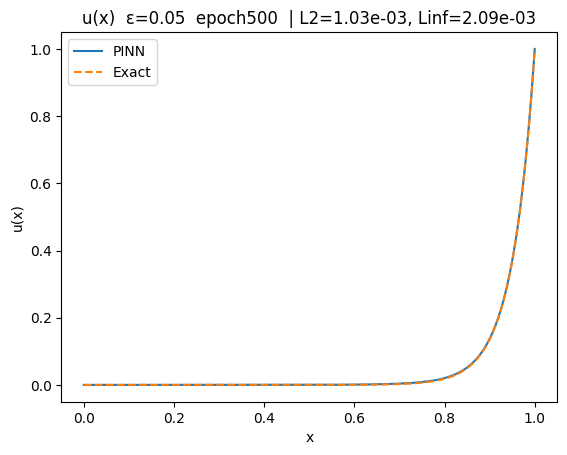

BC check: u(0)=0.00000, u(1)=1.00000, u'(0)=0.00041, u'(1)=19.95152
[ε=0.05] epoch  600/2000 | total=8.75e-08 | PDE=8.74e-08 | PHI=7.20e-09 | λ≈0.898
[ε=0.05] epoch  700/2000 | total=5.96e-08 | PDE=5.96e-08 | PHI=6.76e-09 | λ≈0.898
[ε=0.05] epoch  800/2000 | total=3.64e-08 | PDE=3.63e-08 | PHI=6.94e-09 | λ≈0.898
[ε=0.05] epoch  900/2000 | total=2.49e-08 | PDE=2.49e-08 | PHI=6.97e-09 | λ≈0.898
[ε=0.05] epoch 1000/2000 | total=1.65e-08 | PDE=1.65e-08 | PHI=6.89e-09 | λ≈0.898


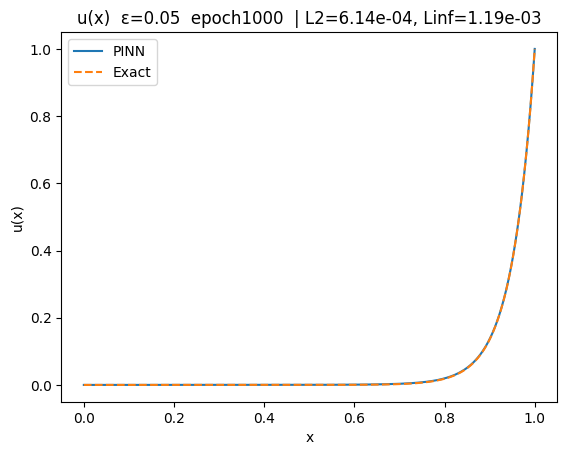

BC check: u(0)=0.00000, u(1)=1.00000, u'(0)=0.00008, u'(1)=19.97363
[ε=0.05] epoch 1100/2000 | total=1.15e-08 | PDE=1.15e-08 | PHI=6.44e-09 | λ≈0.898
[ε=0.05] epoch 1200/2000 | total=8.03e-09 | PDE=7.97e-09 | PHI=6.55e-09 | λ≈0.898
[ε=0.05] epoch 1300/2000 | total=6.91e-09 | PDE=6.85e-09 | PHI=6.38e-09 | λ≈0.898
[ε=0.05] epoch 1400/2000 | total=5.36e-09 | PDE=5.30e-09 | PHI=6.36e-09 | λ≈0.898
[ε=0.05] epoch 1500/2000 | total=4.66e-09 | PDE=4.60e-09 | PHI=6.07e-09 | λ≈0.898


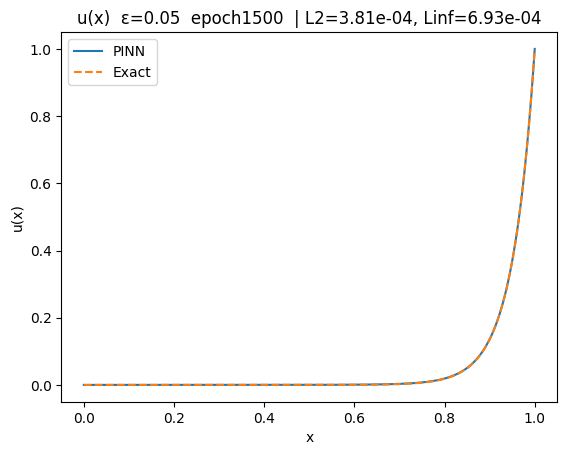

BC check: u(0)=0.00000, u(1)=1.00000, u'(0)=-0.00001, u'(1)=19.98486
[ε=0.05] epoch 1600/2000 | total=4.41e-09 | PDE=4.35e-09 | PHI=5.97e-09 | λ≈0.898
[ε=0.05] epoch 1700/2000 | total=4.46e-08 | PDE=4.45e-08 | PHI=8.84e-09 | λ≈0.898
[ε=0.05] epoch 1800/2000 | total=3.49e-05 | PDE=3.49e-05 | PHI=1.35e-08 | λ≈0.899
[ε=0.05] epoch 1900/2000 | total=1.20e-08 | PDE=1.19e-08 | PHI=1.63e-08 | λ≈0.899
[ε=0.05] epoch 2000/2000 | total=5.61e-09 | PDE=5.44e-09 | PHI=1.65e-08 | λ≈0.899


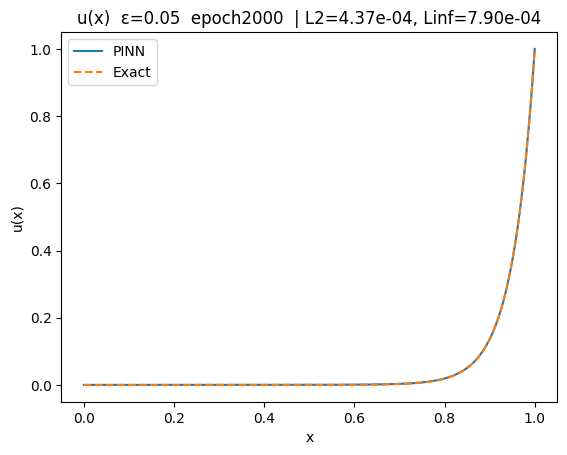

BC check: u(0)=0.00000, u(1)=1.00000, u'(0)=0.00006, u'(1)=19.98219

==== Train at ε = 0.01 | layer_side=right | BC_L=('dirichlet', 0.0) | BC_R=('dirichlet', 1.0) ====
[ε=0.01] epoch  100/2000 | total=4.05e-07 | PDE=4.02e-07 | PHI=3.21e-07 | λ≈0.905
[ε=0.01] epoch  200/2000 | total=1.69e-07 | PDE=1.66e-07 | PHI=3.08e-07 | λ≈0.905
[ε=0.01] epoch  300/2000 | total=1.03e-07 | PDE=1.00e-07 | PHI=3.07e-07 | λ≈0.906
[ε=0.01] epoch  400/2000 | total=8.15e-08 | PDE=7.85e-08 | PHI=2.92e-07 | λ≈0.906
[ε=0.01] epoch  500/2000 | total=6.29e-08 | PDE=6.00e-08 | PHI=2.90e-07 | λ≈0.906


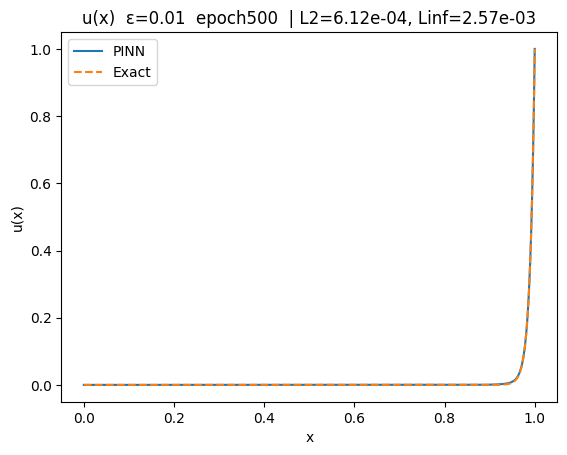

BC check: u(0)=0.00000, u(1)=1.00000, u'(0)=0.00018, u'(1)=99.72888
[ε=0.01] epoch  600/2000 | total=5.59e-08 | PDE=5.30e-08 | PHI=2.85e-07 | λ≈0.906
[ε=0.01] epoch  700/2000 | total=4.97e-08 | PDE=4.67e-08 | PHI=2.97e-07 | λ≈0.906
[ε=0.01] epoch  800/2000 | total=4.18e-08 | PDE=3.89e-08 | PHI=2.86e-07 | λ≈0.906
[ε=0.01] epoch  900/2000 | total=3.78e-08 | PDE=3.47e-08 | PHI=3.04e-07 | λ≈0.906
[ε=0.01] epoch 1000/2000 | total=3.58e-08 | PDE=3.29e-08 | PHI=2.91e-07 | λ≈0.906


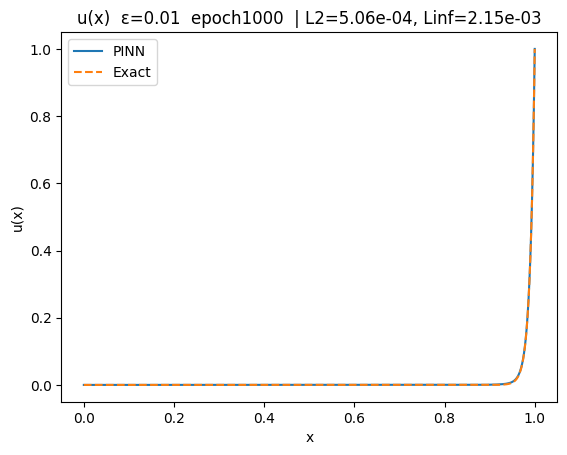

BC check: u(0)=0.00000, u(1)=1.00000, u'(0)=0.00010, u'(1)=99.78450
[ε=0.01] epoch 1100/2000 | total=3.11e-08 | PDE=2.83e-08 | PHI=2.86e-07 | λ≈0.906
[ε=0.01] epoch 1200/2000 | total=2.75e-08 | PDE=2.47e-08 | PHI=2.83e-07 | λ≈0.906
[ε=0.01] epoch 1300/2000 | total=2.36e-08 | PDE=2.09e-08 | PHI=2.72e-07 | λ≈0.906
[ε=0.01] epoch 1400/2000 | total=1.99e-08 | PDE=1.70e-08 | PHI=2.93e-07 | λ≈0.906
[ε=0.01] epoch 1500/2000 | total=1.93e-08 | PDE=1.65e-08 | PHI=2.76e-07 | λ≈0.906


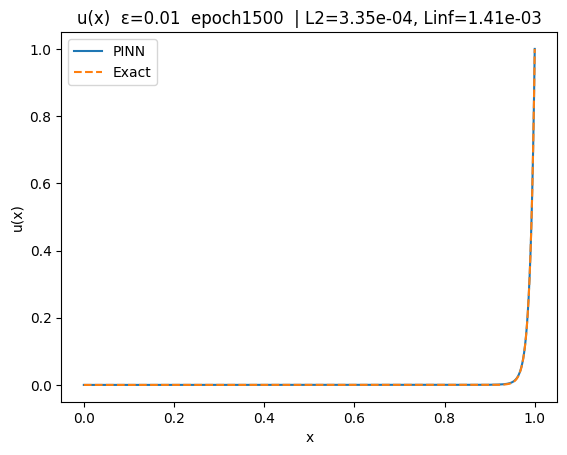

BC check: u(0)=0.00000, u(1)=1.00000, u'(0)=0.00003, u'(1)=99.85899
[ε=0.01] epoch 1600/2000 | total=1.65e-08 | PDE=1.39e-08 | PHI=2.55e-07 | λ≈0.906
[ε=0.01] epoch 1700/2000 | total=1.41e-08 | PDE=1.13e-08 | PHI=2.77e-07 | λ≈0.906
[ε=0.01] epoch 1800/2000 | total=1.25e-08 | PDE=9.83e-09 | PHI=2.66e-07 | λ≈0.906
[ε=0.01] epoch 1900/2000 | total=1.25e-08 | PDE=9.70e-09 | PHI=2.75e-07 | λ≈0.906
[ε=0.01] epoch 2000/2000 | total=9.62e-09 | PDE=7.08e-09 | PHI=2.54e-07 | λ≈0.906


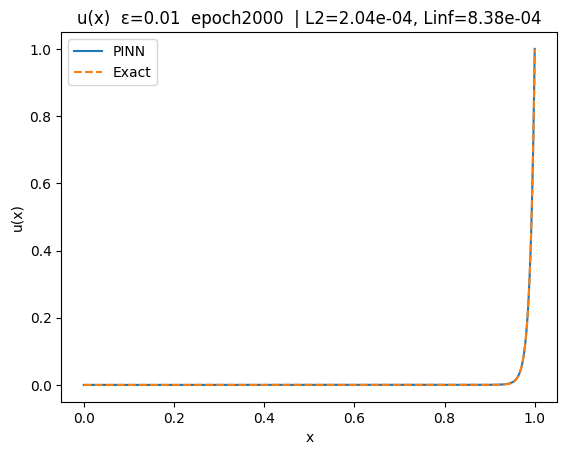

BC check: u(0)=0.00000, u(1)=1.00000, u'(0)=-0.00001, u'(1)=99.91260

==== Train at ε = 0.005 | layer_side=right | BC_L=('dirichlet', 0.0) | BC_R=('dirichlet', 1.0) ====
[ε=0.005] epoch  100/2000 | total=6.49e-09 | PDE=3.82e-09 | PHI=2.68e-07 | λ≈0.906
[ε=0.005] epoch  200/2000 | total=4.89e-09 | PDE=2.26e-09 | PHI=2.63e-07 | λ≈0.906
[ε=0.005] epoch  300/2000 | total=4.81e-09 | PDE=2.07e-09 | PHI=2.74e-07 | λ≈0.906
[ε=0.005] epoch  400/2000 | total=4.57e-09 | PDE=1.99e-09 | PHI=2.58e-07 | λ≈0.906
[ε=0.005] epoch  500/2000 | total=4.50e-09 | PDE=1.97e-09 | PHI=2.53e-07 | λ≈0.906


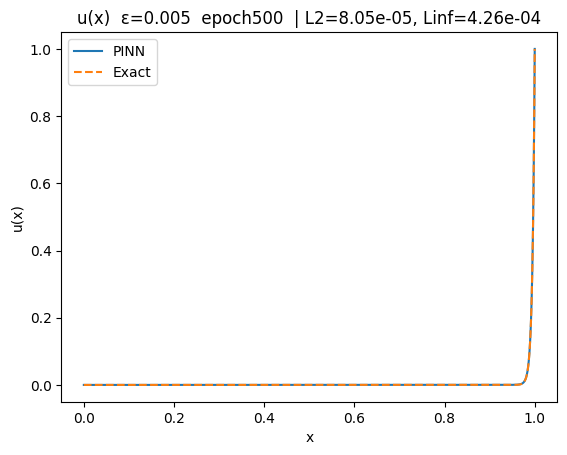

BC check: u(0)=0.00000, u(1)=1.00000, u'(0)=-0.00004, u'(1)=199.87195
[ε=0.005] epoch  600/2000 | total=4.25e-09 | PDE=1.82e-09 | PHI=2.43e-07 | λ≈0.906
[ε=0.005] epoch  700/2000 | total=4.47e-09 | PDE=1.95e-09 | PHI=2.52e-07 | λ≈0.906
[ε=0.005] epoch  800/2000 | total=4.28e-09 | PDE=1.70e-09 | PHI=2.58e-07 | λ≈0.906
[ε=0.005] epoch  900/2000 | total=4.97e-09 | PDE=2.44e-09 | PHI=2.53e-07 | λ≈0.906
[ε=0.005] epoch 1000/2000 | total=4.91e-09 | PDE=2.49e-09 | PHI=2.42e-07 | λ≈0.906


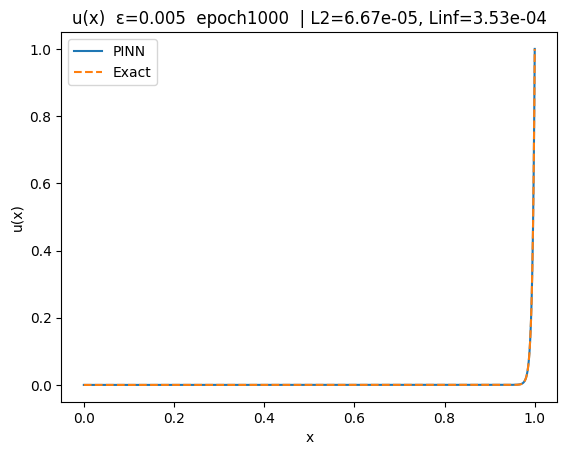

BC check: u(0)=0.00000, u(1)=1.00000, u'(0)=-0.00006, u'(1)=199.89169
[ε=0.005] epoch 1100/2000 | total=4.45e-09 | PDE=2.14e-09 | PHI=2.31e-07 | λ≈0.906
[ε=0.005] epoch 1200/2000 | total=4.08e-09 | PDE=1.68e-09 | PHI=2.41e-07 | λ≈0.906
[ε=0.005] epoch 1300/2000 | total=4.43e-09 | PDE=2.01e-09 | PHI=2.42e-07 | λ≈0.906
[ε=0.005] epoch 1400/2000 | total=4.54e-09 | PDE=2.17e-09 | PHI=2.37e-07 | λ≈0.906
[ε=0.005] epoch 1500/2000 | total=5.14e-09 | PDE=2.65e-09 | PHI=2.48e-07 | λ≈0.906


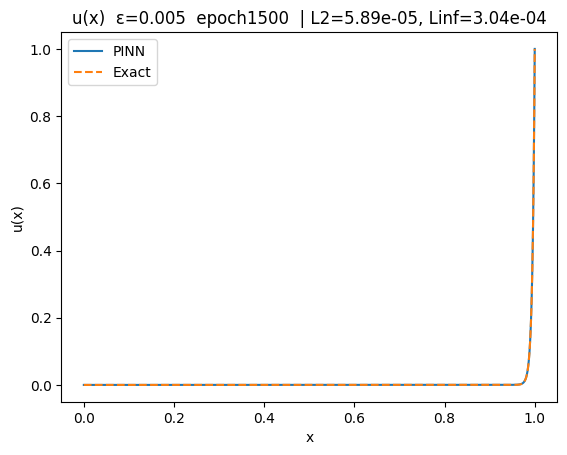

BC check: u(0)=0.00000, u(1)=1.00000, u'(0)=-0.00006, u'(1)=199.90999
[ε=0.005] epoch 1600/2000 | total=5.93e-09 | PDE=3.55e-09 | PHI=2.39e-07 | λ≈0.906
[ε=0.005] epoch 1700/2000 | total=5.10e-09 | PDE=2.80e-09 | PHI=2.29e-07 | λ≈0.906
[ε=0.005] epoch 1800/2000 | total=3.85e-09 | PDE=1.59e-09 | PHI=2.25e-07 | λ≈0.906
[ε=0.005] epoch 1900/2000 | total=4.07e-09 | PDE=1.79e-09 | PHI=2.28e-07 | λ≈0.906
[ε=0.005] epoch 2000/2000 | total=4.66e-09 | PDE=2.44e-09 | PHI=2.21e-07 | λ≈0.906


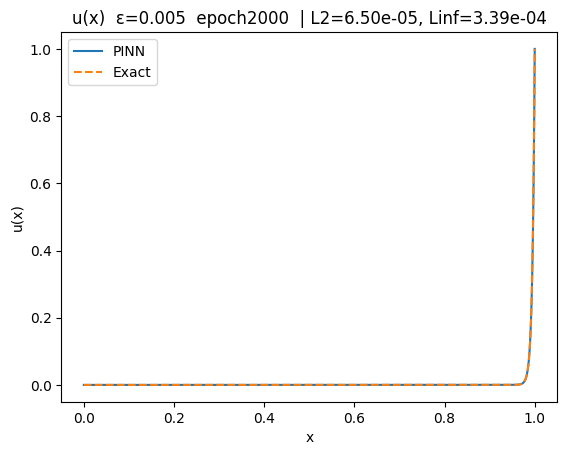

BC check: u(0)=0.00000, u(1)=1.00000, u'(0)=-0.00005, u'(1)=199.92044

==== Train at ε = 0.001 | layer_side=right | BC_L=('dirichlet', 0.0) | BC_R=('dirichlet', 1.0) ====
[ε=0.001] epoch  100/2000 | total=2.96e-09 | PDE=6.70e-10 | PHI=2.29e-07 | λ≈0.906
[ε=0.001] epoch  200/2000 | total=3.25e-09 | PDE=1.03e-09 | PHI=2.22e-07 | λ≈0.906
[ε=0.001] epoch  300/2000 | total=2.93e-09 | PDE=6.58e-10 | PHI=2.27e-07 | λ≈0.906
[ε=0.001] epoch  400/2000 | total=3.18e-09 | PDE=1.01e-09 | PHI=2.17e-07 | λ≈0.906
[ε=0.001] epoch  500/2000 | total=4.12e-08 | PDE=3.89e-08 | PHI=2.24e-07 | λ≈0.906


/var/folders/43/gn5zgyr90093pcc_54nyjbjm0000gn/T/ipykernel_33806/2745172682.py:12: RuntimeWarning: overflow encountered in exp
  num = np.exp(x_np/eps) - 1.0
/var/folders/43/gn5zgyr90093pcc_54nyjbjm0000gn/T/ipykernel_33806/2745172682.py:13: RuntimeWarning: overflow encountered in exp
  den = np.exp(1.0/eps) - 1.0
/var/folders/43/gn5zgyr90093pcc_54nyjbjm0000gn/T/ipykernel_33806/2745172682.py:14: RuntimeWarning: invalid value encountered in divide
  return (alpha + (beta - alpha) * (num/den)).astype(np.float64)


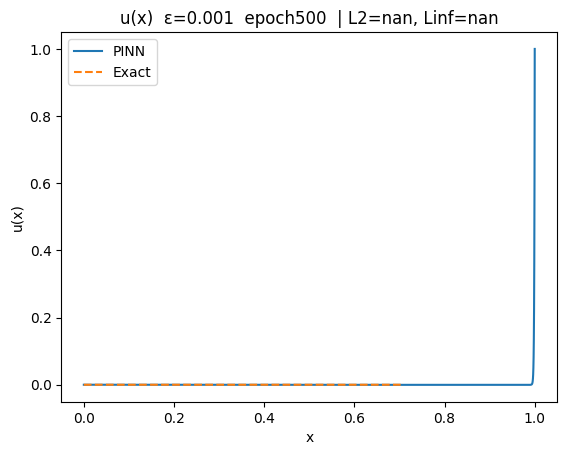

BC check: u(0)=0.00000, u(1)=1.00000, u'(0)=0.00001, u'(1)=1000.37463
[ε=0.001] epoch  600/2000 | total=3.68e-09 | PDE=1.61e-09 | PHI=2.08e-07 | λ≈0.906
[ε=0.001] epoch  700/2000 | total=3.16e-09 | PDE=1.05e-09 | PHI=2.11e-07 | λ≈0.906
[ε=0.001] epoch  800/2000 | total=2.55e-09 | PDE=4.59e-10 | PHI=2.09e-07 | λ≈0.906
[ε=0.001] epoch  900/2000 | total=3.46e-06 | PDE=3.46e-06 | PHI=2.08e-07 | λ≈0.906
[ε=0.001] epoch 1000/2000 | total=3.18e-09 | PDE=1.09e-09 | PHI=2.08e-07 | λ≈0.906


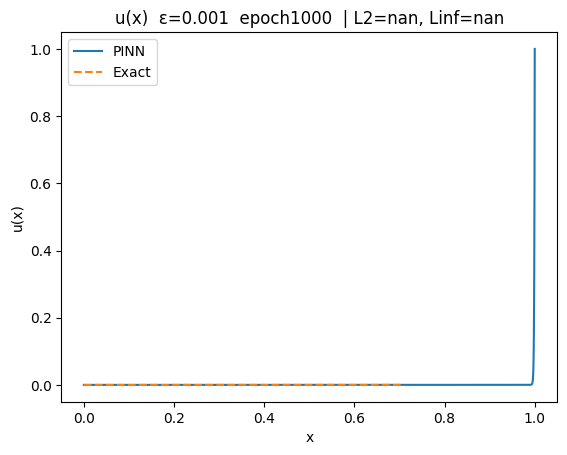

BC check: u(0)=0.00000, u(1)=1.00000, u'(0)=-0.00002, u'(1)=999.69977
[ε=0.001] epoch 1100/2000 | total=2.51e-09 | PDE=5.17e-10 | PHI=2.00e-07 | λ≈0.906
[ε=0.001] epoch 1200/2000 | total=5.87e-08 | PDE=5.67e-08 | PHI=2.03e-07 | λ≈0.906
[ε=0.001] epoch 1300/2000 | total=2.87e-09 | PDE=8.52e-10 | PHI=2.02e-07 | λ≈0.906
[ε=0.001] epoch 1400/2000 | total=2.66e-09 | PDE=6.46e-10 | PHI=2.01e-07 | λ≈0.906
[ε=0.001] epoch 1500/2000 | total=2.50e-09 | PDE=5.00e-10 | PHI=2.00e-07 | λ≈0.906


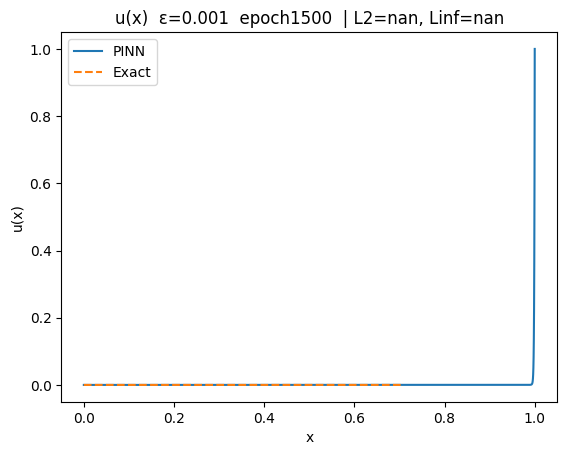

BC check: u(0)=0.00000, u(1)=1.00000, u'(0)=-0.00005, u'(1)=999.62268
[ε=0.001] epoch 1600/2000 | total=6.51e-07 | PDE=6.49e-07 | PHI=1.80e-07 | λ≈0.906
[ε=0.001] epoch 1700/2000 | total=5.41e-09 | PDE=3.34e-09 | PHI=2.07e-07 | λ≈0.906
[ε=0.001] epoch 1800/2000 | total=2.30e-09 | PDE=4.60e-10 | PHI=1.84e-07 | λ≈0.906
[ε=0.001] epoch 1900/2000 | total=2.26e-09 | PDE=4.07e-10 | PHI=1.85e-07 | λ≈0.906
[ε=0.001] epoch 2000/2000 | total=9.87e-08 | PDE=9.68e-08 | PHI=1.85e-07 | λ≈0.906


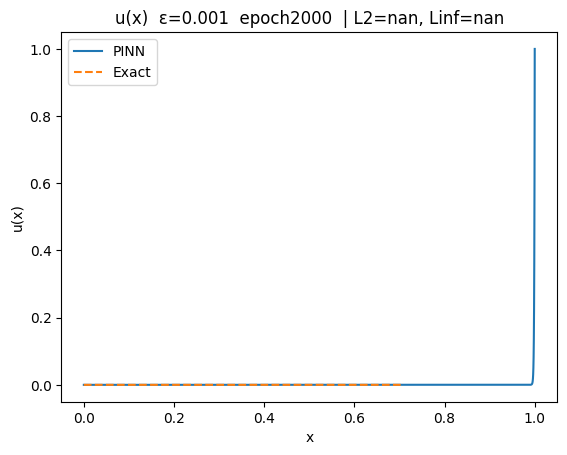

BC check: u(0)=0.00000, u(1)=1.00000, u'(0)=-0.00002, u'(1)=999.77454


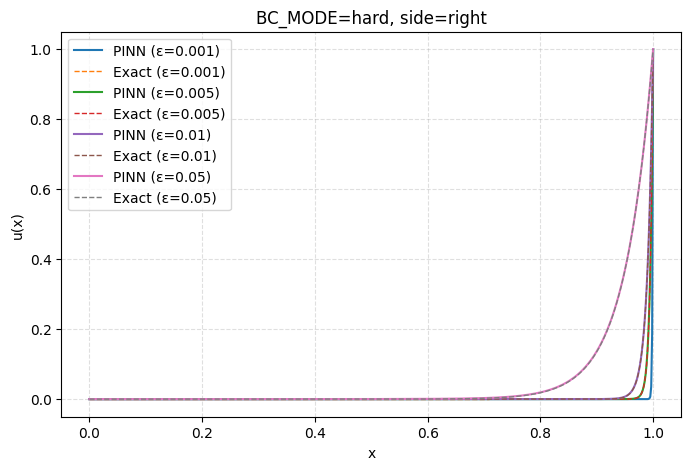

Training finished.


In [46]:
# PDE: -ε u'' + u' = 0  (you can replace b, c, f as needed)
def b_fun(x): return torch.ones_like(x)
def c_fun(x): return torch.zeros_like(x)
def f_fun(x): return torch.zeros_like(x)

# Analytic solution for Dirichlet–Dirichlet only (used as a visual reference).
# For other BC combinations, disable the exact comparison.
def exact_solution(x_np, eps):
    alpha, beta = 0.0, 1.0   # Dirichlet BC values

    x_np = np.asarray(x_np, dtype=np.float64)
    num = np.exp(x_np/eps) - 1.0
    den = np.exp(1.0/eps) - 1.0
    return (alpha + (beta - alpha) * (num/den)).astype(np.float64)


# Example A: right boundary layer
# (Left: Dirichlet α = 0, Right: Dirichlet β = 1)
LAYER_SIDE = 'right'; BC_LEFT = ('dirichlet', 0.0); BC_RIGHT = ('dirichlet', 1.0)
EPS_LIST = [5e-2, 1e-2, 5e-3, 1e-3]
train(EPS_LIST, layer_side=LAYER_SIDE, bc_left=BC_LEFT, bc_right=BC_RIGHT)


# Hyperparameter Documentation


---

## 1) Boundary Layer and Boundary Conditions

- **`LAYER_SIDE`** — Side where the boundary layer is expected.  
  - Options: `'left'` | `'right'`  
  - Example:
    ```python
    LAYER_SIDE = 'right'
    ```

- **`BC_LEFT`, `BC_RIGHT`** — Boundary conditions at \(x=0\) and \(x=1\).  
  - Format:
    - `('dirichlet', α)`  → Dirichlet BC \(u = $\alpha$\)
    - `('neumann', q)`   → Neumann BC \(u' = q\)
  - Example:
    ```python
    BC_LEFT  = ('dirichlet', 0.0)
    BC_RIGHT = ('dirichlet', 1.0)
    ```

---

## 2) Training Parameters

- **`EPS_LIST`** — List of $\epsilon$ values to sweep.  
  - Example:
    ```python
    EPS_LIST = [5e-2, 1e-2, 5e-3, 1e-3]
    ```

- **`NCOL`, `NEDGE`** — Interior collocation points vs. boundary/edge-focused points.  
  - Example:
    ```python
    NCOL, NEDGE = 2048, 512
    ```

- **`EPOCHS_PER_STAGE`** — Epochs per training stage (e.g., per-ε schedule).
  ```python
  EPOCHS_PER_STAGE = 2000
  ```

- **`PRINT_EVERY`, `PLOT_EVERY`** — Logging and visualization frequency (in steps).
  ```python
  PRINT_EVERY = 100
  PLOT_EVERY  = 500
  ```

- **`LR`** — Optimizer learning rate.
  ```python
  LR = 1e-3
  ```

- **`BC_MODE`** — How boundary conditions are imposed.  
  - `'hard'`: encode BCs into the solution ansatz.  
  - `'soft'`: add a boundary penalty term to the loss.
  ```python
  BC_MODE = 'hard'
  ```

- **`LAM_BC`** — Boundary penalty weight used **only when** `BC_MODE = 'soft'`.
  ```python
  LAM_BC = 1.0
  ```

---

## 3) Branch-Gated / φ Regularization

- **`S0, S1, kappa`** — Region-splitting / gating parameters (inner / transition / outer).
  ```python
  S0, S1, kappa = 5.0, 7.0, 2.0
  ```

- **`lam_comp`** — Compatibility/consistency penalty of transition band.
  ```python
  lam_comp = 0.05
  ```

- **`tau, eta_phi`** — Regularization for the learned coordinate transform $\phi(x)$
  ```python
  tau, eta_phi = 0.1, 1e-4
  ```

- **`lam_pde, lam_phi`** — Weights for PDE residual and \(\phi\)-regularization terms.
  ```python
  lam_pde, lam_phi = 1.0, 0.01
  ```

---

## 4) PDE Coefficients and (Optional) Exact Solution

- **General PDE form**
  
  $- \epsilon\, u''(x) + b(x)\, u'(x) + c(x)\, u(x) = f(x)$
  

- **Coefficient stubs** — provide your problem-specific definitions:
  ```python
  def b_fun(x): ...
  def c_fun(x): ...
  def f_fun(x): ...
  ```

- **Exact solution (optional)** — if an analytical solution exists for your chosen
  \(b(x), c(x), f(x)\) and BCs, you can implement it for visualization/validation:
  ```python
  def exact_solution(x_np, eps):
      # return a NumPy array with u(x) for plotting / error metrics
  ```

